<a href="https://colab.research.google.com/github/davyandr/pet-projects/blob/main/ab/ab_cookie_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! gdown 1JfcgRNIBTnRZtcZoLKeZbXX14Mf01deb

https://drive.google.com/file/d/1JfcgRNIBTnRZtcZoLKeZbXX14Mf01deb/view?usp=sharing \
https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy import stats as ss
import warnings
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
from statsmodels.stats.proportion import proportions_ztest

In [3]:
df = pd.read_csv('/content/cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
df.version = df.version.apply(lambda x: 'variant' if x == 'gate_40' else 'control')

In [5]:
print(df.query('version == "control"').userid.nunique(), ' ', df.query('version == "variant"').userid.nunique())

44700   45489


In [6]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,control,3,False,False
1,337,control,38,True,False
2,377,variant,165,True,False
3,483,variant,1,False,False
4,488,variant,179,True,True


## Sum gamerounds

$H_0$ : mean sum_gamerounds(control) = mean sum_gamerounds(variant) \
$H_1$ : mean sum_gamerounds(control) ≠ mean sum_gamerounds(variant)

In [7]:
print(df.query('version == "control"').sum_gamerounds.mean(), ' ', df.query('version == "variant"').sum_gamerounds.mean())

52.45626398210291   51.29877552814966


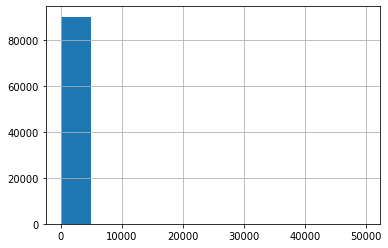

In [8]:
df.sum_gamerounds.hist();

In [10]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    from scipy.stats import zscore, norm
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/5000 [00:00<?, ?it/s]

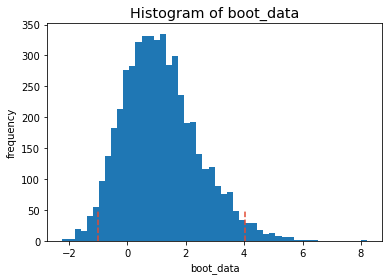

In [11]:
booted_data = get_bootstrap(df.query('version == "control"').sum_gamerounds, df.query('version == "variant"').sum_gamerounds, boot_it = 5000, statistic=np.mean)

In [12]:
print(('0 in the 95% confidence interval, statistics are equal' if booted_data['ci'].iat[0, 0] * booted_data['ci'].iat[1, 0] <= 0 else '0 outside the 95% confidence interval, statistics are equal'))
print('Bootstraped mean test, p_value:', round(booted_data["p_value"], 3), ('<>' if booted_data["p_value"] <= 0.05 else '='))

0 in the 95% confidence interval, statistics are equal
Bootstraped mean test, p_value: 0.376 =


We cannot reject the $H_0$

## Retention 1 day

$H_0$ : retention(control) = retention(variant) \
$H_1$ : retention(control) ≠ retention(variant)

In [13]:
df.groupby('version').agg({'retention_1': ['mean', 'count']})

retention_1       
               mean  count
version                   
control    0.448188  44700
variant    0.442283  45489

In [14]:
df.groupby('version').agg({'retention_1': ['sum', 'count']})

retention_1       
                sum  count
version                   
control       20034  44700
variant       20119  45489

In [15]:
a1 = df[df['version'] == 'control']['retention_1']
b1 = df[df['version'] == 'variant']['retention_1']

In [16]:
stat, pval = proportions_ztest([a1.sum(), b1.sum()], [len(a1), len(b1)])

In [24]:
print('Z-test, p_value:', round(pval, 3), ('=>  distributions of samples are not equal' if pval <= 0.05 else '=>  distributions of samples are equal'))

Z-test, p_value: 0.002 =>  distributions of samples are not equal


We cannot reject the $H_0$

## Retention 7 day

$H_0$ : retention(control) = retention(variant) \
$H_1$ : retention(control) ≠ retention(variant)

In [18]:
df.groupby('version').agg({'retention_7': ['mean', 'count']})

retention_7       
               mean  count
version                   
control    0.190201  44700
variant    0.182000  45489

In [19]:
df.groupby('version').agg({'retention_7': ['sum', 'count']})

retention_7       
                sum  count
version                   
control        8502  44700
variant        8279  45489

In [20]:
a7 = df[df['version'] == 'control']['retention_7']
b7 = df[df['version'] == 'variant']['retention_7']

In [21]:
stat, pval = proportions_ztest([a7.sum(), b7.sum()], [len(a7), len(b7)])

In [23]:
print('Z-test, p_value:', round(pval, 3), ('=>  distributions of samples are not equal' if pval <= 0.05 else '=>  distributions of samples are equal'))

Z-test, p_value: 0.002 =>  distributions of samples are not equal


We reject the $H_0$ and accept $H_1$, but control version is more successful

##Conclusion: don't make changes